# Practical Work 06 

## Exercise 3 – MLP with TensorFlow 2.0
The objective of the exercise is to implement computational graphs in TensorFlow 2.0 to train and use such an architecture. The constraints we put ourselves is to use **low-level** functions of TensorFlow, i.e. we will not use high-level functions to compose layers and to train the parameters.

If you get this error in the execution of the first cell: ` ModuleNotFoundError: No module named 'tensorflow' `, it probably means TensorFlow 2.0 is not installed yet on your machine.

In [3]:
#############################
# MNIST Dataset Preparation #
#############################

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

mnist = tf.keras.datasets.mnist
(x_train, y_train_vec),(x_test, y_test_vec) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train_vec, 10, dtype='float64')
y_test = tf.keras.utils.to_categorical(y_test_vec, 10, dtype='float64')
N = x_train.shape[0]         # number of samples
D = x_train.shape[1]         # dimension of input sample
n_classes = y_train.shape[1] # output dim
print('MNIST data set ready. N={}, D={}, n_classes={}'.format(N,D,n_classes))

MNIST data set ready. N=60000, D=784, n_classes=10


In [12]:
# Function to sample a random batch from dataset
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0,len(data))  # create an array of index values
    np.random.shuffle(idx)        # shuffle it
    idx = idx[:num]               # take the first n indexes = size of batch
    data_shuffle = data[idx]      # extract the batch using the random indexes
    labels_shuffle = labels[idx]  # extract the labels using the random indexes

    return data_shuffle, labels_shuffle

In [5]:
##################
# Training phase #
##################

E = 50                # number of epochs
B = 128               # batch size
N = x_train.shape[0]  # number of samples
D = x_train.shape[1]  # dimension of input sample
H = 300               # number of neurons
A = 0.01              # learning rate

In [13]:
# Build the computational graph
@tf.function # this decorator tells tf that a graph is defined
def mlp_train(x, y, alpha):
    h = tf.maximum(tf.matmul(x, w1) + b1, 0.0) # ReLU
    y_pred = tf.sigmoid(tf.matmul(h, w2) + b2) # Sigmoid
    
    # Loss
    diff = y_pred - y
    loss = tf.reduce_mean(tf.pow(diff, 2))
    
    grad_w1, grad_b1, grad_w2, grad_b2 = tf.gradients(ys=loss, xs=[w1, b1, w2, b2])
    w1.assign(w1 - alpha * grad_w1)
    b1.assign(b1 - alpha * grad_b1)
    w2.assign(w2 - alpha * grad_w2)
    b2.assign(b2 - alpha * grad_b2)
    return y_pred, loss

# Init the tf.Variables
w1 = tf.Variable(tf.random.truncated_normal((D, H), stddev = 0.1, dtype='float64'))
b1 = tf.Variable(tf.constant(0.0, shape=[H], dtype='float64'))
w2 = tf.Variable(tf.random.truncated_normal((H, n_classes), stddev = 0.1, dtype='float64'))
b2 = tf.Variable(tf.constant(0.0, shape=[n_classes], dtype='float64'))

# Run the computational graph
J = [] # to store the evolution of loss J for each epoch
for epoch in range(E):
    J_epoch = 0.0
    for _ in range(int(N/B)): # number of batches to visit for 1 epoch
        x_train_batch, y_train_batch = next_batch(B, x_train, y_train)
        with tf.device('/CPU:0'):  # change to /GPU:0 to move it to GPU
            out = mlp_train(x_train_batch, y_train_batch, A)
        y_pred, loss_val = out
        J_epoch += loss_val
    J.append(J_epoch)
    print("epoch = {}, loss = {}".format(epoch, J_epoch))

epoch = 0, loss = 59.14524762784337
epoch = 1, loss = 41.11387827880607
epoch = 2, loss = 38.339728687719415
epoch = 3, loss = 35.67575023850617
epoch = 4, loss = 33.15644525854705
epoch = 5, loss = 30.77669422473733
epoch = 6, loss = 28.797473839360467
epoch = 7, loss = 27.34133559975266
epoch = 8, loss = 25.900322048375063
epoch = 9, loss = 24.86068029501293
epoch = 10, loss = 23.755633593985134
epoch = 11, loss = 22.906431193419806
epoch = 12, loss = 22.15302910619862
epoch = 13, loss = 21.2813177195502
epoch = 14, loss = 20.72970960640927
epoch = 15, loss = 20.087229795950666
epoch = 16, loss = 19.682110277424748
epoch = 17, loss = 19.09325480688519
epoch = 18, loss = 18.706569017422442
epoch = 19, loss = 18.239183491728998
epoch = 20, loss = 17.77183224970661
epoch = 21, loss = 17.482066347140364
epoch = 22, loss = 17.05122542196194
epoch = 23, loss = 16.856398608856
epoch = 24, loss = 16.491958622062167
epoch = 25, loss = 16.22817586408131
epoch = 26, loss = 15.739731408432982
ep

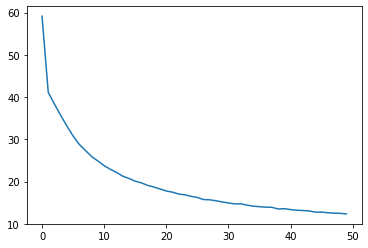

In [14]:
# Plot the evolution of the loss
plt.plot(J)

In [15]:
#################
# Testing phase #
#################

N = x_test.shape[0]  # number of samples
D = x_test.shape[1]  # dimension of input sample

# Build the computational graph
@tf.function # this decorator tells tf that a graph is defined
def mlp_test(x, y):
    h = tf.maximum(tf.matmul(x, w1) + b1, 0.0)
    y_pred = tf.sigmoid(tf.matmul(h, w2) + b2)
    return y_pred

# Run the computational graph
with tf.device('/CPU:0'):  # change to /GPU:0 to move it to GPU
    y_pred_test = mlp_test(x_test, y_test)

print('Forward pass on test set done.')

Forward pass on test set done.


In [16]:
# compute accuracy
y_winner = np.argmax(y_pred_test, axis=1)
N_test = y_winner.size
num_correct = (y_winner == y_test_vec).sum()
num_missed = N_test - num_correct
accuracy = num_correct * 1.0 / N_test
error_rate = num_missed * 1.0 / N_test
print('# samples  : ', N_test)
print('# correct  : ', num_correct)
print('# missed   : ', num_missed)
print('accuracy   :  %2.2f %%'% (accuracy*100.0))
print('error rate :  %2.2f %%'% (error_rate*100.0))

# samples  :  10000
# correct  :  8786
# missed   :  1214
accuracy   :  87.86 %
error rate :  12.14 %


## Exercise 4 – MLP with TensorFlow 2.0 and Keras

In [17]:
model = tf.keras.models.Sequential()

# Add the hidden and output layers
model.add(tf.keras.layers.Dense(H, input_shape=(D,), use_bias=True, activation='relu'))
model.add(tf.keras.layers.Dense(n_classes, input_shape=(H,), use_bias=True, activation='sigmoid'))

model.summary()

sgd = tf.keras.optimizers.SGD(learning_rate=A)

model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=B, epochs=E)

model.evaluate(x_test, y_test, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
469/469 [==============================] - 1s 1ms/step - loss: 0.1772 - accuracy: 0.1339
Epoch 2/50
469/469 [==============================] - 1s 1ms/step - loss: 0.0927 - accuracy: 0.3424
Epoch 3/50
469/469 [==============================] - 1s 1ms/step - loss: 0.0856 - accuracy: 0.4324
Epoch 4/50
469/469 [==============================] - 1s 1ms/step - loss: 0.0815 - accuracy: 0.4677
Epoch 5/50
469/469 [==============================] - 1s 1ms/step - loss: 0.0780 - accuracy: 0.5010
Epoch 6/50
4

[0.02757449261844158, 0.8812999725341797]

dict_keys(['loss', 'accuracy'])


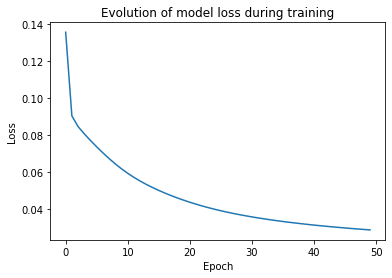

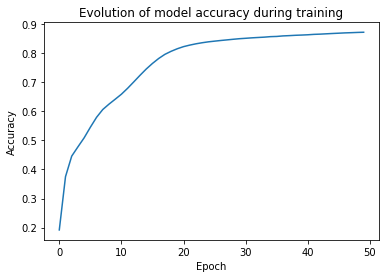

In [18]:
# list all data in history
print(history.history.keys())

# plot/summarize history for loss and accuracy
plt.plot(history.history['loss'])
plt.title('Evolution of model loss during training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
plt.plot(history.history['accuracy'])
plt.title('Evolution of model accuracy during training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

### With Softmax and a cross-entropy loss

In [6]:
model = tf.keras.models.Sequential()

# Add the hidden and output layers
model.add(tf.keras.layers.Dense(H, input_shape=(D,), use_bias=True, activation='relu'))
model.add(tf.keras.layers.Dense(n_classes, input_shape=(H,), use_bias=True, activation='softmax'))

model.summary()

sgd = tf.keras.optimizers.SGD(learning_rate=A)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=B, epochs=E)

model.evaluate(x_test, y_test, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
469/469 [==============================] - 1s 949us/step - loss: 1.5272 - accuracy: 0.6085
Epoch 2/50
469/469 [==============================] - 0s 989us/step - loss: 0.5648 - accuracy: 0.8646
Epoch 3/50
469/469 [==============================] - 0s 921us/step - loss: 0.4384 - accuracy: 0.8867
Epoch 4/50
469/469 [==============================] - 0s 919us/step - loss: 0.3849 - accuracy: 0.8947
Epoch 5/50
469/469 [==============================] - 0s 910us/step - loss: 0.3576 - accuracy: 0.9018


[0.13694977760314941, 0.9603999853134155]

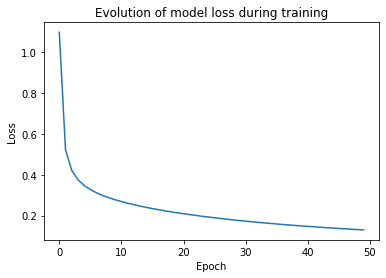

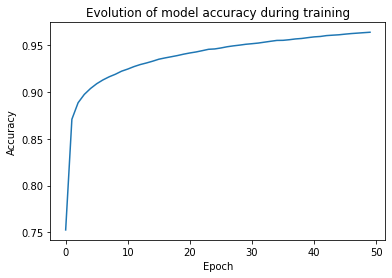

In [8]:
# plot/summarize history for loss and accuracy
plt.plot(history.history['loss'])
plt.title('Evolution of model loss during training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
plt.plot(history.history['accuracy'])
plt.title('Evolution of model accuracy during training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()